<h1 style="text-align: center;">MODEL INTERPRETATION</h1>

### Import the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch.nn as nn 
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy
import pandas

from joblib import load

import shap
from captum.attr import IntegratedGradients
shap.initjs()

### Load the Data

In [2]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = load(r"../data/preprocessed_data.joblib")

### Load the Model

In [3]:
class ClassifierNN(nn.Module):
    """
        Neural network classifier.

        Parameters
        ----------
        activation_function : torch.nn.Module
            The activation function to be used in the network.

        Attributes
        ----------
        activation_function : torch.nn.Module
            The activation function for the network.
        fcn1 : torch.nn.Linear
            The first fully connected layer with input size 14 and output size 32.
        fcn2 : torch.nn.Linear
            The second fully connected layer with input size 32 and output size 64.
        fcn3 : torch.nn.Linear
            The third fully connected layer with input size 64 and output size 128.
        fcn4 : torch.nn.Linear
            The fourth fully connected layer with input size 128 and output size 2.

        Methods
        -------
        forward(x)
            Forward pass of the neural network.

    """

    def __init__(self):
        super().__init__()
        OPTIMAL_ACTIVATION_FUNCTION = F.relu

        self.activation_function = OPTIMAL_ACTIVATION_FUNCTION

        # Define fully connected layers
        self.fcn1 = nn.Linear(14, 32)
        self.fcn2 = nn.Linear(32, 64)
        self.fcn3 = nn.Linear(64, 128)
        self.fcn4 = nn.Linear(128, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
            Forward pass of the neural network.

            Parameters
            ----------
            x : torch.Tensor
                Input tensor with shape (-1, 14).

            Returns
            -------
            torch.Tensor
                Output tensor after the forward pass.
        """
        x = x.view(-1, 14)

        x = self.activation_function(self.fcn1(x))
        x = self.activation_function(self.fcn2(x))
        x = self.activation_function(self.fcn3(x))

        x = self.fcn4(x)

        return x

In [4]:
BEST_MODEL = ClassifierNN()

BEST_MODEL.load_state_dict(torch.load(r"../data/mlp_parameters_tensor.pth"))

<All keys matched successfully>

In [5]:
BEST_MODEL.eval()

ClassifierNN(
  (fcn1): Linear(in_features=14, out_features=32, bias=True)
  (fcn2): Linear(in_features=32, out_features=64, bias=True)
  (fcn3): Linear(in_features=64, out_features=128, bias=True)
  (fcn4): Linear(in_features=128, out_features=2, bias=True)
)

### Data for Local Interpretability (Positive)

In [6]:
# Sample data to use for local interpretability (POSITIVE)
SAMPLE_INDEX_POSITIVE  = -1
INPUT_DATA_POSITIVE = X_TEST.iloc[SAMPLE_INDEX_POSITIVE]
LABEL_POS = Y_TEST.to_list()[SAMPLE_INDEX_POSITIVE]

In [7]:
INPUT_DATA_POSITIVE = X_TEST.iloc[SAMPLE_INDEX_POSITIVE]
INPUT_DATA_POSITIVE

Age                     0.75
Color               0.714286
Transparency            0.25
Glucose                  0.4
Protein                 0.75
pH                  0.333333
Specific Gravity         0.4
WBC                 0.166667
RBC                      0.0
Epithelial Cells    0.333333
Mucous Threads           0.0
Amorphous Urates         0.0
Bacteria                 1.0
FEMALE                  True
Name: 1003, dtype: object

In [8]:
LABEL_POS

1

### Data for Local Interpretability (Negative)

In [9]:
# Sample data to use for local interpretability (NEGATIVE)
SAMPLE_INDEX_NEGATIVE  = 0
INPUT_DATA_NEGATIVE = X_TEST.iloc[SAMPLE_INDEX_NEGATIVE]
LABEL_NEG = Y_TEST.to_list()[SAMPLE_INDEX_NEGATIVE]

In [10]:
INPUT_DATA_NEGATIVE = X_TEST.iloc[SAMPLE_INDEX_NEGATIVE]
INPUT_DATA_NEGATIVE

Age                 0.684783
Color               0.714286
Transparency            0.25
Glucose                  0.0
Protein                  0.0
pH                       0.0
Specific Gravity         0.8
WBC                 0.333333
RBC                      0.0
Epithelial Cells    0.666667
Mucous Threads      0.333333
Amorphous Urates    0.166667
Bacteria                 0.6
FEMALE                  True
Name: 0, dtype: object

In [11]:
LABEL_NEG

0

### Local Interpretability (Integrated Gradient Analysis)

In [12]:
def integrated_gradients_analysis(model: torch.nn.Module, input_data: pandas.core.frame.DataFrame, label: int) -> numpy.ndarray:
    """
        Perform Integrated Gradients analysis on the given model.

        Parameters
        ----------
        model : torch.nn.Module
            The PyTorch model to analyze.
        input_data : pandas.DataFrame
            Input data for analysis in the form of a pandas DataFrame.
        label : int
            The target label for which the analysis is conducted.

        Returns
        -------
        attribution_np : numpy.ndarray
            An array representing the attribution scores obtained through Integrated Gradients analysis.

        Notes
        -----
        Integrated Gradients is an attribution method that assigns importance scores to input features
        based on the model's output. This function computes the attribution scores for a given input
        data and target label using the Integrated Gradients technique.

        The input_data should be in the form of a pandas DataFrame, and the label should be specified
        as an integer. The analysis is performed by attributing the prediction for the target label
        with respect to the input features.

        Example
        -------
        >>> model = YourPyTorchModel()
        >>> input_data = pd.DataFrame({"feature1": [value1], "feature2": [value2], ...})
        >>> label = 1
        >>> attribution_scores = integrated_gradients_analysis(model, input_data, label)
    """

    # Convert input_data to a PyTorch tensor
    INPUT_TENSOR = torch.from_numpy(input_data.to_numpy(dtype="float32")).float().unsqueeze(0)

    # Prepare target and baseline tensors
    TARGET_TENSOR = torch.tensor(label, dtype=torch.long)
    BASELINE_TENSOR = torch.zeros_like(INPUT_TENSOR)

    # Initialize Integrated Gradients object
    INTEGRATED_GRADIENTS = IntegratedGradients(model)

    # Compute attribution scores
    ATTRIBUTION = INTEGRATED_GRADIENTS.attribute(INPUT_TENSOR, target=TARGET_TENSOR, n_steps=50, baselines=BASELINE_TENSOR)

    # Convert attribution tensor to numpy array
    ATTRIBUTION_NP = ATTRIBUTION.squeeze(0).detach().numpy()

    return ATTRIBUTION_NP

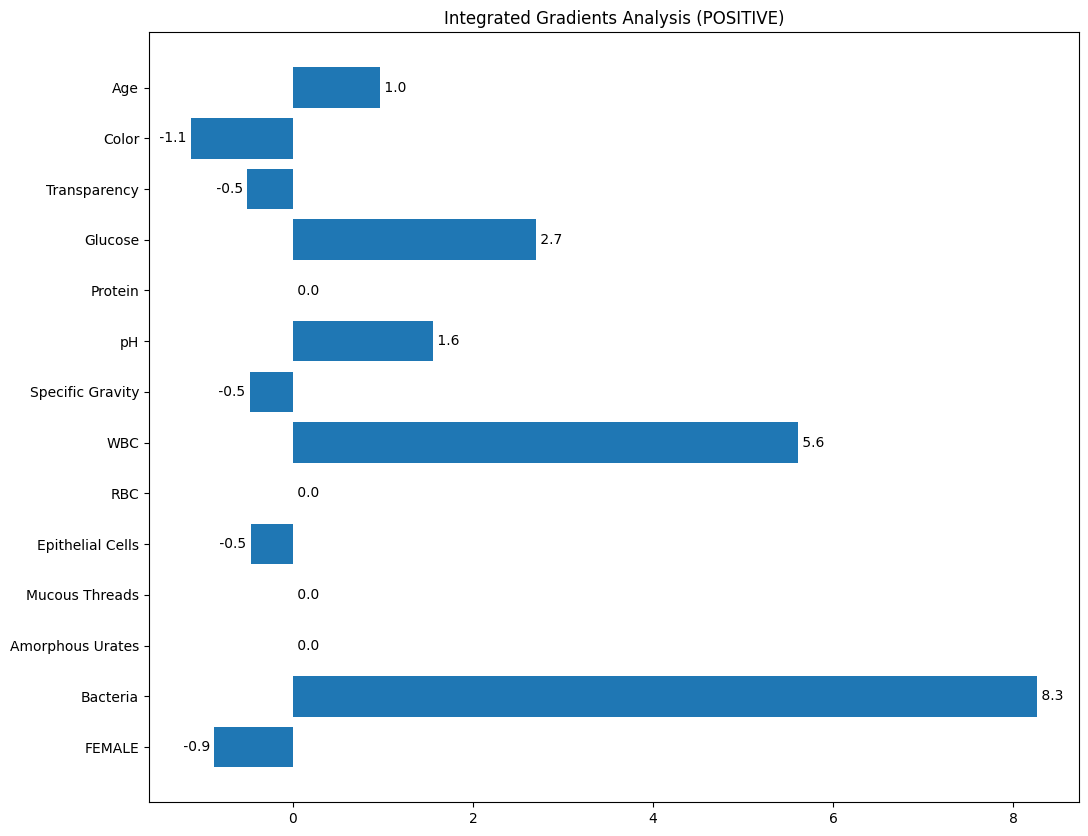

In [13]:
ATTRIBUTION_MAP = integrated_gradients_analysis(BEST_MODEL, INPUT_DATA_POSITIVE, LABEL_POS)

_, AXS = plt.subplots(figsize=(12, 10))

bar_graph = AXS.barh(X_TRAIN.columns, ATTRIBUTION_MAP)

CONTAINER = AXS.containers[0]
AXS.bar_label(bar_graph, labels=[f' {x:,.1f} ' for x in CONTAINER.datavalues])

AXS.set_title("Integrated Gradients Analysis (POSITIVE)")
AXS.invert_yaxis()
plt.show()

### Local Interpretability (SHAP)

In [14]:
# Convert boolean values to integers in the "FEMALE" column of X_train_unscaled
X_TRAIN["FEMALE"] = [1 if bool_ else 0 for bool_ in X_TRAIN["FEMALE"]]

# Convert boolean values to integers in the "FEMALE" column of X_test_unscaled
X_TEST["FEMALE"] = [1 if bool_ else 0 for bool_ in X_TEST["FEMALE"]]

In [15]:
INPUT_DATA = X_TEST.values.astype('float32')
INPUT_TENSOR = torch.tensor(INPUT_DATA)

In [16]:
EXPLAINER = shap.DeepExplainer(BEST_MODEL, INPUT_TENSOR)

In [17]:
SHAP_VALUES = EXPLAINER.shap_values(INPUT_TENSOR, check_additivity=False)

#### Local Positive

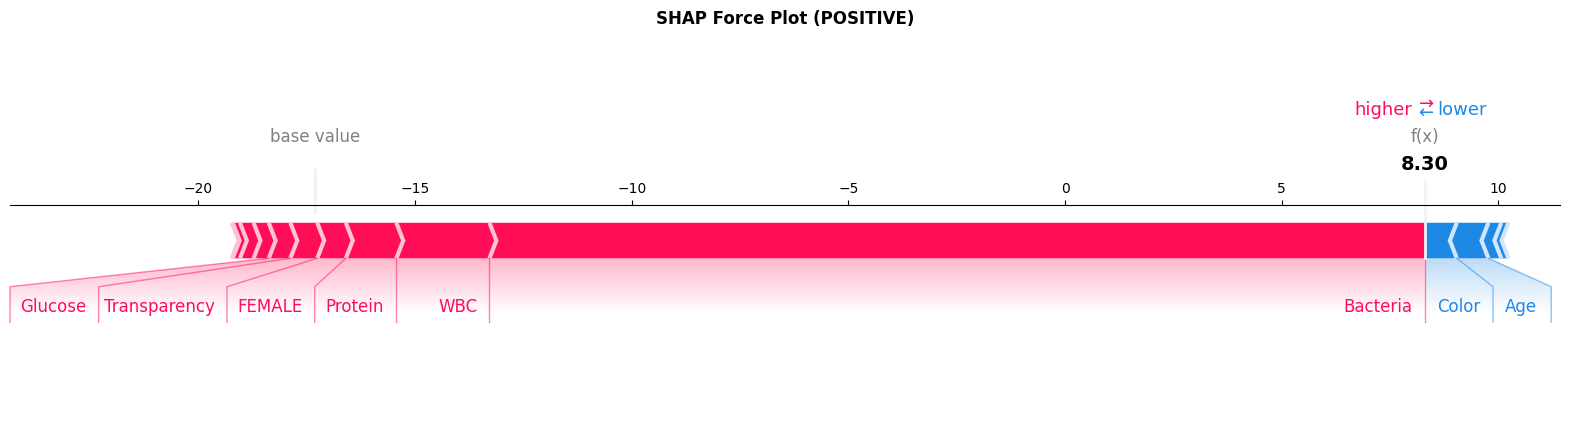

In [18]:
shap.force_plot(EXPLAINER.expected_value[1], SHAP_VALUES[1][SAMPLE_INDEX_POSITIVE], X_TRAIN.columns, matplotlib=True, show=False)
plt.title("SHAP Force Plot (POSITIVE)", fontdict={"fontweight":"bold"}, y=1.75)
plt.show()

#### Local Negative

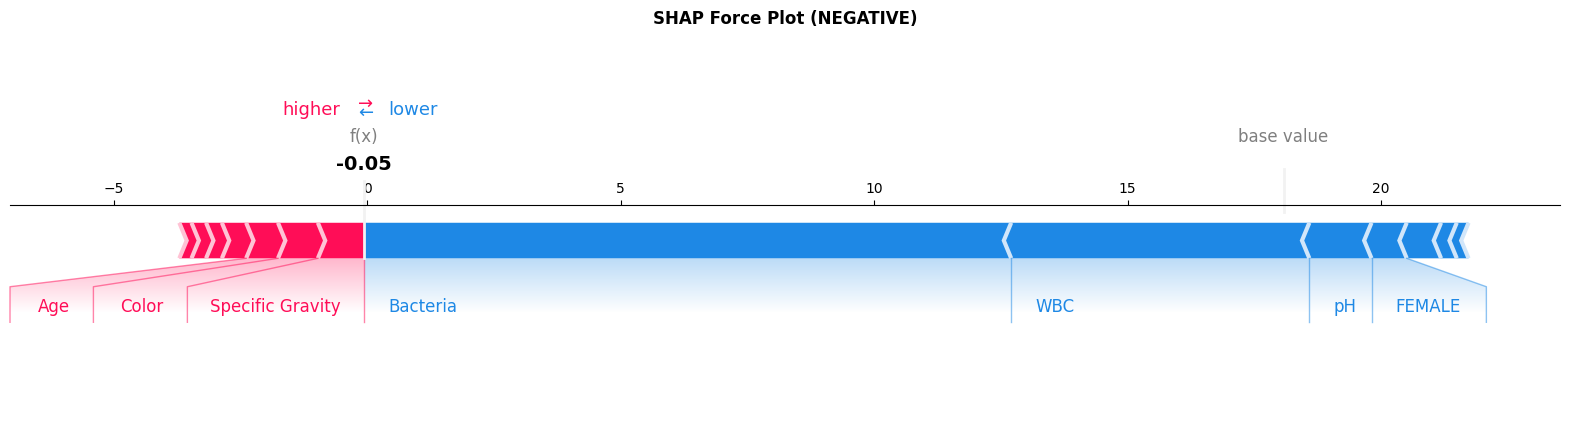

In [19]:
shap.force_plot(EXPLAINER.expected_value[0], SHAP_VALUES[0][SAMPLE_INDEX_NEGATIVE], X_TRAIN.columns, matplotlib=True, show=False)
plt.title("SHAP Force Plot (NEGATIVE)", fontdict={"fontweight":"bold"}, y=1.75)
plt.show()

### Global Interpretability (SHAP)

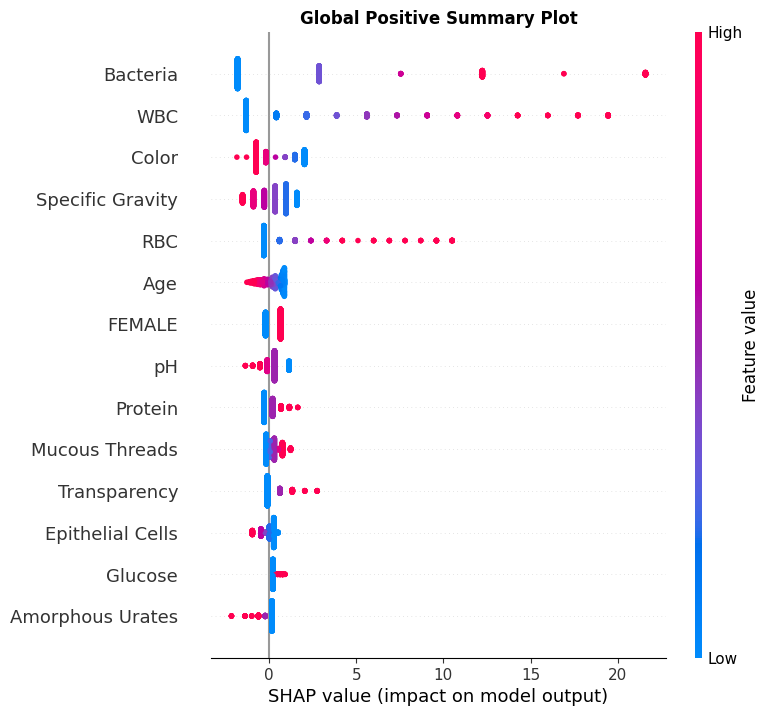

In [20]:
# SHAP Global Positive Summary Plot
shap.summary_plot(SHAP_VALUES[1], X_TEST, show=False)
plt.title("Global Positive Summary Plot", fontdict={"fontweight":"bold"})
plt.show()